## Text Exploration and Classification with Naive Bayes
### Anna Chen - Data Science Project
- Goal: Complete the tasks outlined in this python notebook.
- Python notebook outline created by Marcus Gubanyi.

In [1]:
# import libraries

# Data Handling and Analysis
import pandas as pd
import numpy as np

# Text Processing and NLP
import re
from collections import Counter # Tocenization
import nltk
nltk.download('punkt') # for sentence and word tokenization
nltk.download('stopwords')
nltk.download('wordnet') # for lemmatization - reduces words to their base or root form
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Machine Learning, Vectorization, and cross validation 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.sparse import issparse # to check if vectorized data is sparse

# Word Cloud and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Advanced Vectorization
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\s9602\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\s9602\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\s9602\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### TASK 1: Load Training Dataset (3 points)
Acquire the dataset from the following link.

https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset Citation:

Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).


In [2]:
# Load the dataset
df = pd.read_csv('IMDB Dataset.csv')

# Display the first few rows of the dataset to check it's loaded correctly
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [3]:
# Check for missing values 
missing_values = df.isnull().sum() 
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 review       0
sentiment    0
dtype: int64


### TASK 2: Create a binary target column named "class" (2 points)
"negative" -> 0
"positive" -> 1

Hint: Use the apply function.

In [4]:
# function to convert sentiment to a binary class
def sentiment_to_class(sentiment):
    if sentiment == 'positive':
        return 1
    elif sentiment == 'negative':
        return 0

# create the 'class' column by apply the function to the 'sentiment' column
df['class'] = df['sentiment'].apply(sentiment_to_class)

# Check result
print(df.head())

                                              review sentiment  class
0  One of the other reviewers has mentioned that ...  positive      1
1  A wonderful little production. <br /><br />The...  positive      1
2  I thought this was a wonderful way to spend ti...  positive      1
3  Basically there's a family where a little boy ...  negative      0
4  Petter Mattei's "Love in the Time of Money" is...  positive      1


### TASK 3: Explore the data (20 points)
Perform exploratory analysis on the text documents. You may reference other people's ideas and code, but must cite what you find.

Ideas to consider: Word Cloud, Most Common Words, etc.

Note that you may need to install and import additional libraries depending on what analysis you do.



In [5]:
def combine_and_preprocess_text(df, column):
    """
    Combine text from a DataFrame column and preprocess it by tokenizing, removing stop words, and lemmatizing.
    
    Args:
        df (pandas.DataFrame): The DataFrame containing the text data.
        column (str): The name of the column with text to combine.
    
    Returns:
        str: A single string with all text combined and preprocessed.
    """
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    combined_text = " ".join(review for review in df[column])
    
    # Tokenize and remove stop words
    words = nltk.word_tokenize(combined_text)
    words = [word for word in words if word.lower() not in stop_words and word.isalpha()]
    
    # Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)


In [41]:
def remove_br(text):
    """ Accepts and returns a single string, removing 'br' from the text. """
    
    return re.sub(r'\bbr\b', '', text)

In [7]:
def plot_word_frequency(text, title):
    """
    Calculate word frequency and display the word frequency plot.
    
    Args:
        text (str): A single preprocessed string to generate the plot from.
        title (str): The title to display on the plot.
    """
    # Word Tokenization: Splits text into individual words
    tokens = word_tokenize(text)

    # Calculate word frequency
    word_freq = Counter(tokens)
    most_common_words = word_freq.most_common(20)
    freq_df = pd.DataFrame(most_common_words, columns=['word', 'frequency'])

    # Display word frequency plot
    plt.figure(figsize=(10, 5))
    sns.barplot(x='frequency', y='word', data=freq_df)
    plt.title("Top 20 Most Common Words in " + title)
    plt.show()


In [8]:
def generate_word_cloud(text, title):
    """
    Generates and displays a word cloud from the given text.
    
    Args:
        text (str): A single string to generate the word cloud from.
        title (str): The title to display on the word cloud plot.
    """
    
    # Handle type error
    if not isinstance(text, str):
        raise TypeError("The input text must be a single string.")
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.title("Word Cloud for " + title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [9]:
def TFIDF_wordcloud(text, title):
    """
    Generates a TFIDF-based word cloud and displays it.

    Args:
        text (str, list, or pandas.Series): A single string, a list of strings, or a pandas Series of reviews.
        title (str): The title to display on the word cloud plot.
    """
    
    # Ensure the input is in a suitable format (list of reviews)
    if isinstance(text, str):
        text = [text]  # Convert a single string to a list
    elif isinstance(text, pd.Series):
        text = text.tolist()
    elif not isinstance(text, list):
        raise TypeError("The input text must be a string, list, or a pandas Series.")
        
    # Initialize the TFIDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    
    # Compute TFIDF scores for the reviews
    tfidf_text = tfidf_vectorizer.fit_transform(text)
    text_features = tfidf_vectorizer.get_feature_names_out()
    text_scores = tfidf_text.toarray().sum(axis=0)
    text_tfidf = dict(zip(text_features, text_scores))

    # Generate word cloud
    text_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(text_tfidf)
    
    plt.figure(figsize=(10, 5))
    plt.title("TFIDF Word Cloud for " + title)
    plt.imshow(text_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


In [10]:
# Combine and preprocess text
all_reviews = combine_and_preprocess_text(df, 'review')
positive_text = combine_and_preprocess_text(df[df['class'] == 1], 'review')
negative_text = combine_and_preprocess_text(df[df['class'] == 0], 'review')

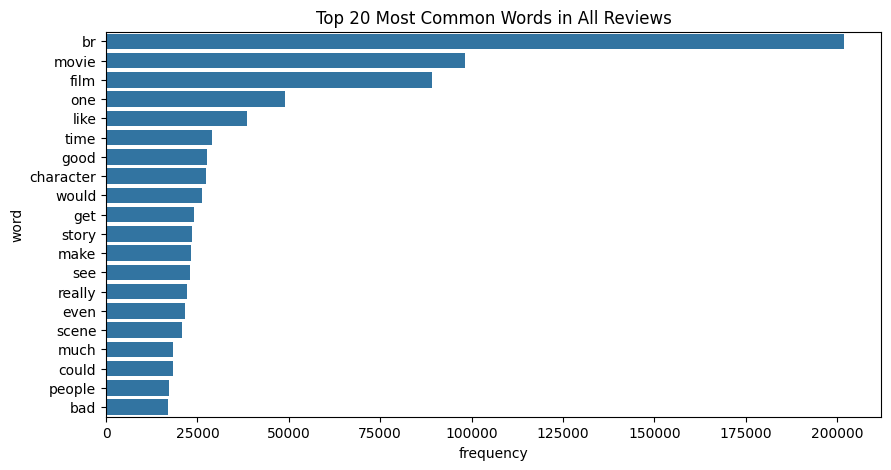

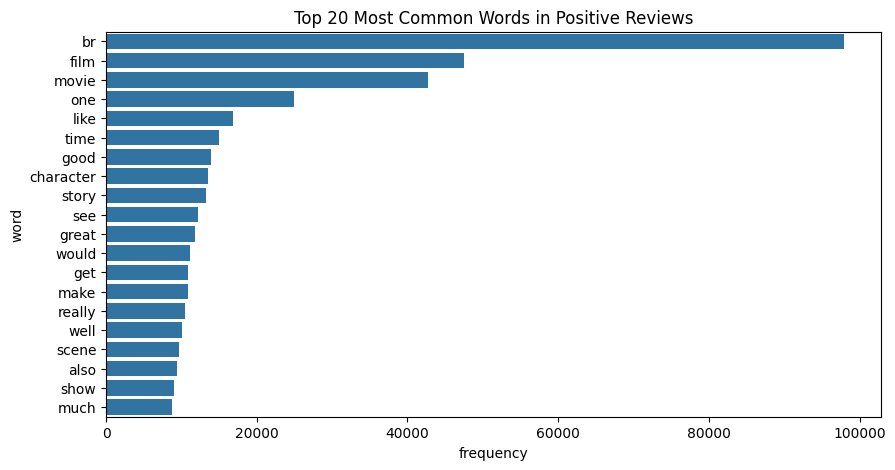

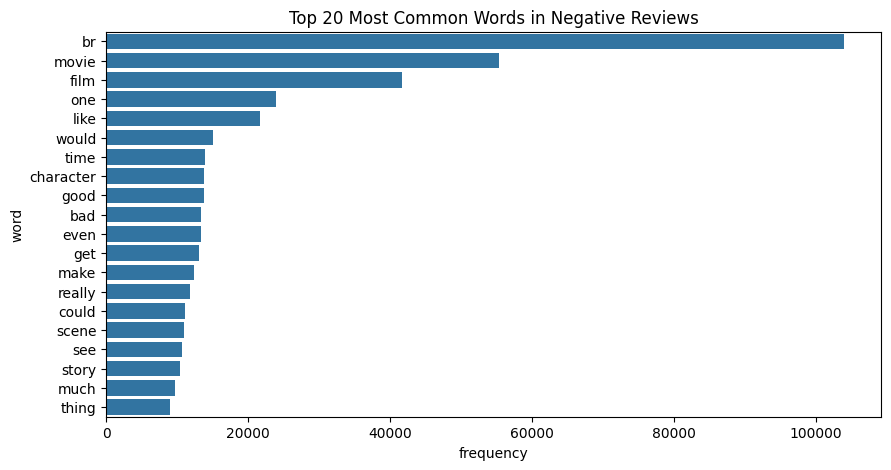

In [11]:
# Generate the word frequency
plot_word_frequency(all_reviews, "All Reviews")
plot_word_frequency(positive_text, "Positive Reviews")
plot_word_frequency(negative_text, "Negative Reviews")

#### All Reviews
The word frequency plot for all reviews shows generic terms, such as "movie," "film," "one," "like," "good," "would," and "even." Weirdly, the word "br" is the most frequent word, this could be due to HTML tags or broken text that have not been cleaned out. These words do not provide clear insight into the reviews, and the "br" needs to be removed.

#### Positive Reviews
Positive reviews highlight words such as "like", "good", "great", and "love", which corresponds with the class "positive".

#### Negative Reviews
Negative reviews contain words like "bad", "like", and "good". Though some phrases overlap with positive reviews, "bad" is a preety good negative sentiment indicator.

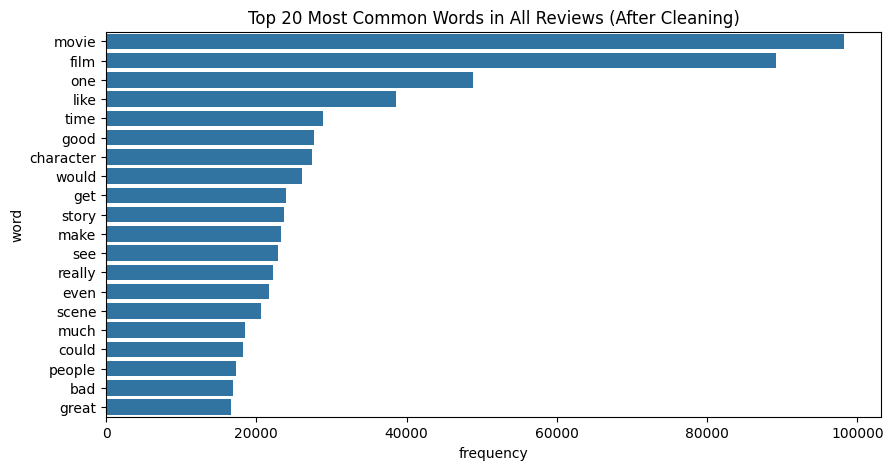

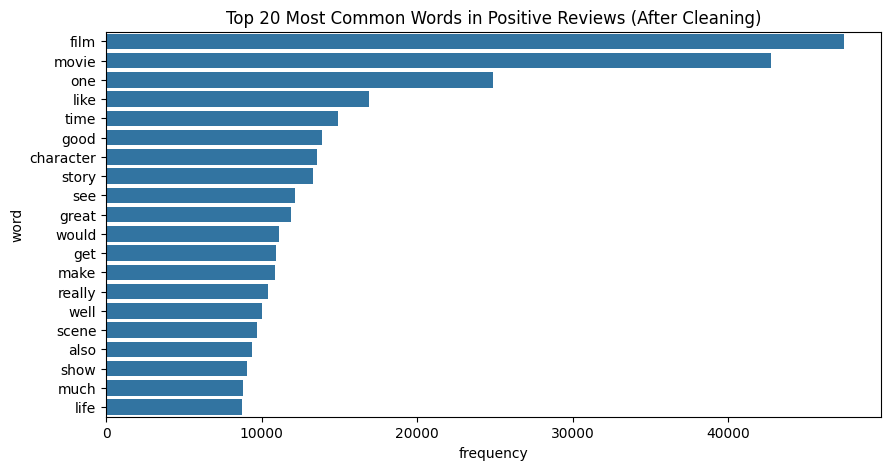

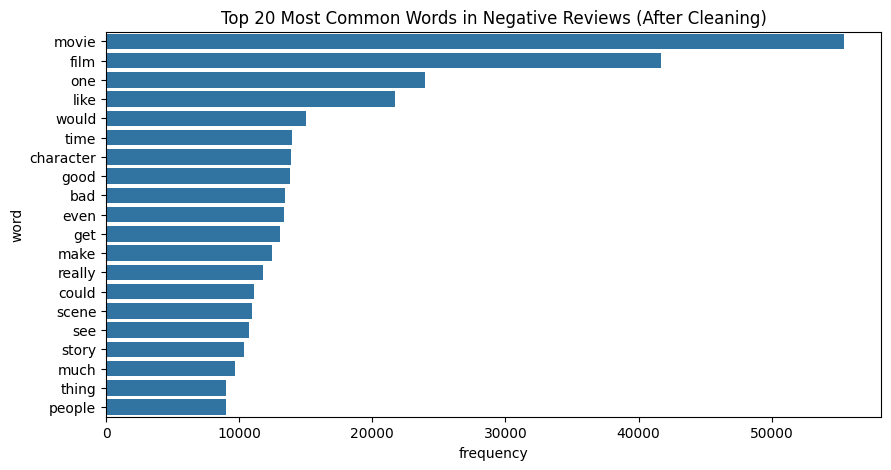

In [12]:
# Remove 'br' tags to make the data cleaner
all_reviews = remove_br(all_reviews)
positive_text = remove_br(positive_text)
negative_text = remove_br(negative_text)

# Generate the word frequency plot after removing 'br'
plot_word_frequency(all_reviews, "All Reviews (After Cleaning)")
plot_word_frequency(positive_text, "Positive Reviews (After Cleaning)")
plot_word_frequency(negative_text, "Negative Reviews (After Cleaning)")


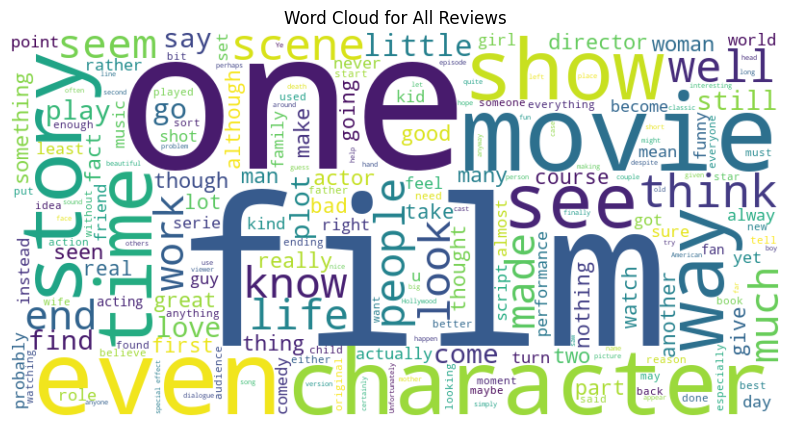

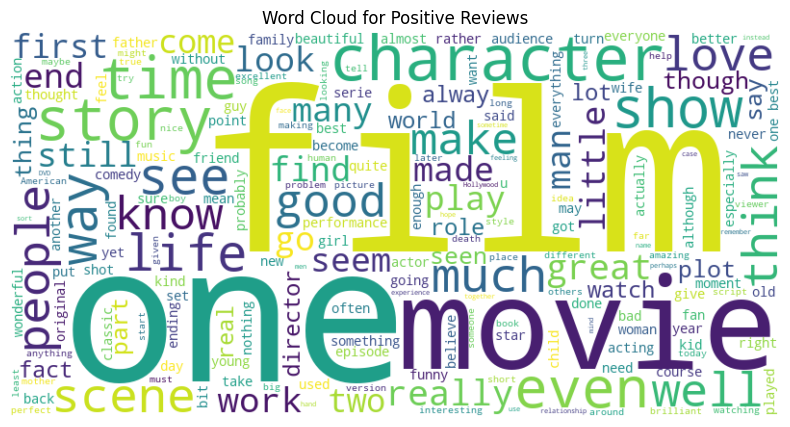

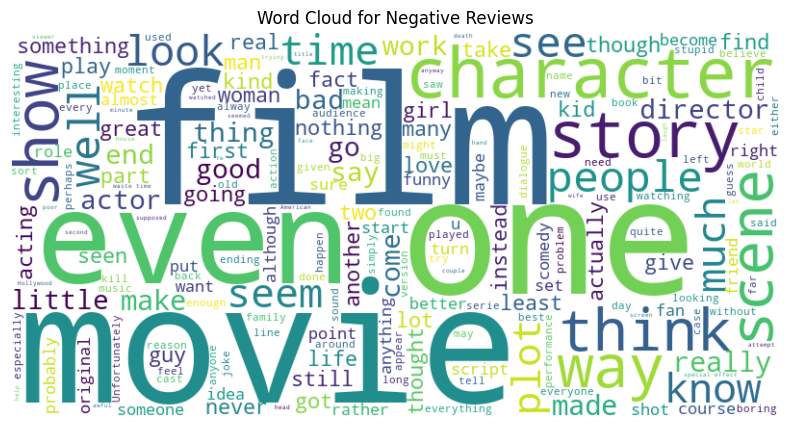

In [13]:
# Generate Wordcloud
generate_word_cloud(all_reviews, "All Reviews")
generate_word_cloud(positive_text, "Positive Reviews")
generate_word_cloud(negative_text, "Negative Reviews")

### Word Cloud Analysis

#### All Reviews
- The most frequent phrases are "film," "one," "even," and "movie." Other significant words include "character," "think," "story," "scene," "show," "see," and "plot." These frequent terms are typical movie-related vocabulary.

#### Positive Reviews
- In the positive reviews word cloud, larger phrases like "film," "movie," "one," "character," "story," and "think" overshadow the positive terms. However, positive words like "love" are still noticeable. Smaller positive phrases like "great" and "good" are present but require closer attention to spot.

#### Negative Reviews
- The most eye-catching phrases in the negative reviews word cloud are still "film," "even," "movie," and "one." The negative word "bad" is visible but relatively small. Interestingly, positive terms such as "love," "good," "great," and "funny" appear almost as big as "bad." Other negative phrases like "stupid," "boring," and "nothing" are harder to find and easy to overlook. This indicates that negative reviews often still include positive terms or are less consistent in their use of negative vocabulary, which may make the model training more challenging.

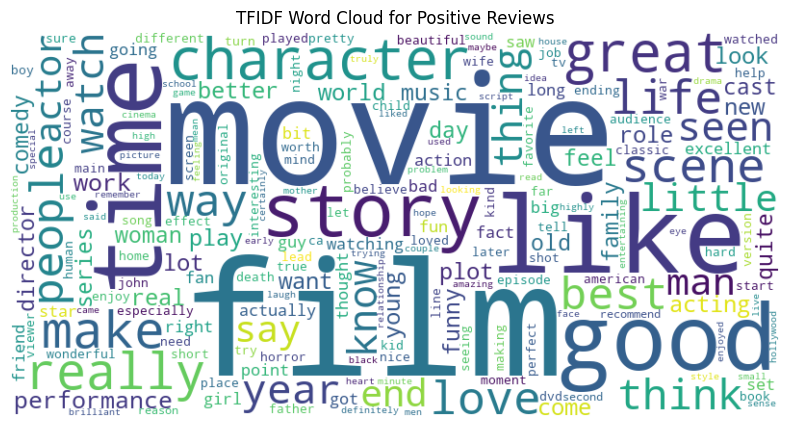

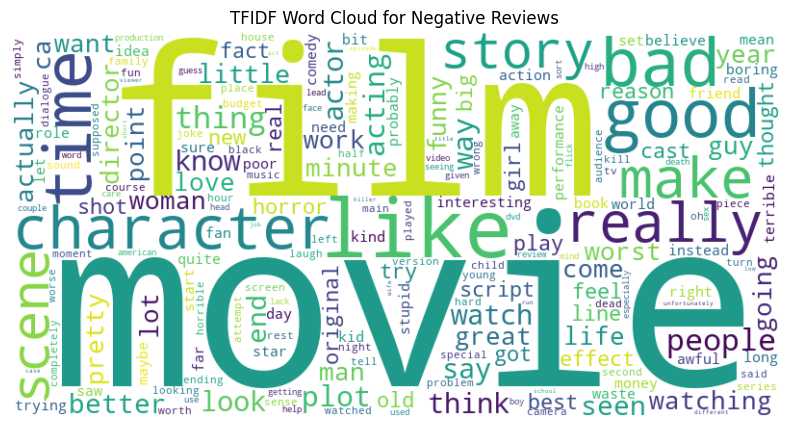

In [14]:
# generate world cloud with TFIDF vectorization
TFIDF_wordcloud(positive_text, "Positive Reviews")
TFIDF_wordcloud(negative_text, "Negative Reviews")

### TF-IDF Word Cloud Analysis

#### Positive Reviews
- The TF-IDF word cloud for positive reviews provides a clearer representation of positive sentiments compared to the normal word cloud. The largest words are all movie-related, such as "film," "movie," "character," "story," and "scene," which are relevant to the context of the reviews, while "one" is removed.
- More noticeable positive words include "good," "best," "love," "like," and "great." If you look closer, smaller positive phrases like "excellent," "fun," "beautiful," "pretty," "perfect," "funny," "better," "interesting," and "enjoy" can also be seen.
- Overall, this word cloud makes it easier to identify positive sentiments among the general movie-related terms.

#### Negative Reviews
- Similar to the positive reviews, the largest words include "movies," "film," "like," and "time." while "one" is not seen.
- The word "bad" is now larger and easier to spot, though "good" remains the same size. Other noticeable phrases include "better," "funny," "best," and "great."
- Taking a closer look reveals smaller negative phrases such as "terrible," "boring," "spectacle," "awful," "poor," "worse," and "horrible," with "interesting" mixed in.
- In conclusion, while the TF-IDF word cloud improves the visibility of negative phrases compared to the normal word cloud, positive terms are still very visible and may overshadow some smaller negative phrases. 

### TASK 4: Vectorize the Training Data (10 points)
Transform the raw text data into vectors. You are encouraged but not required to try complex options.

Simple Options:
1. Count Vectors
2. Binary Vectors
3. TFIDF Vectors

Example Complex Options:
1. Word2Vec (gensim.models.Word2Vec)
2. Transformers such as BERT and GPT 

Example References:
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
https://pypi.org/project/transformers/

In [15]:
# Spilt the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['class'], test_size=0.2, random_state=42)


In [16]:
# Count vector

# Initialize Count Vectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# vectorize training and testing set
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

In [17]:
# TFIDF vector

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# vectorize training and testing set
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [18]:
# Word2Vec

# Tokenize text for Word2Vec
tokenized_train = [review.split() for review in X_train]
tokenized_test = [review.split() for review in X_test]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=1, workers=4)

# Function to
def get_average_word2vec(tokens_list, model, vector_size):
    """ Create average Word2Vec vector. """
    
    vectors = [model.wv[word] for word in tokens_list if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

# Vectorize the training and testing data
X_train_word2vec = np.array([get_average_word2vec(review, word2vec_model, 100) for review in tokenized_train])
X_test_word2vec = np.array([get_average_word2vec(review, word2vec_model, 100) for review in tokenized_test])


### TASK 6: Train and Tune Models (10 points)
Train and tune multiple models (3+). Try out different vectors. Perform cross-validation to find the optimal model for each kind.

Example Models to Consider:
https://scikit-learn.org/stable/modules/naive_bayes.html

In [39]:
# Handle GaussianNB separately to accommodate limited memory

def partial_fit_gaussian_nb(vectorized_data, labels, batch_size=1000):
    """
    Incrementally fit GaussianNB using partial fit with smaller batches.
    
    Expected Arguments:
      vectorized_data: The full dataset already vectorized.
      labels: The target values (categories or classes).
      batch_size: Size of the batches for partial fit.
    
    Outputs:
      Returns the fitted GaussianNB model.
    """
    model = GaussianNB()
    unique_labels = np.unique(labels)

    # Convert labels to numpy array
    labels = np.array(labels)
    
    for start in range(0, vectorized_data.shape[0], batch_size):
        end = min(start + batch_size, vectorized_data.shape[0])
        X_batch = vectorized_data[start:end].toarray()
        y_batch = labels[start:end]
        model.partial_fit(X_batch, y_batch, classes=unique_labels)
    
    return model

def predict_in_batches(model, X_test, batch_size=1000):
    """
    Predict in smaller batches to handle large data sizes.
    
    Expected Arguments:
      model: The trained GaussianNB model.
      X_test: The test data that needs to be predicted.
      batch_size: Size of the batches for prediction.
    
    Outputs:
      Returns the combined predictions for the test data.
    """
    predictions = []
    for start in range(0, X_test.shape[0], batch_size):
        end = min(start + batch_size, X_test.shape[0])
        X_batch = X_test[start:end].toarray()
        batch_predictions = model.predict(X_batch)
        predictions.extend(batch_predictions)
    
    return np.array(predictions)

In [37]:
# Train and tune models

def train_and_evaluate_model(vector_name, vectorized_data, labels, model, batch_size=1000):
    """ 
    Train and validate models with different vector types, including Count Vectors, TF-IDF, and Word2Vec.

    Expected Arguments:
      vector_name: A string that stores the type of vector. Ex: "Count Vector"
      vectorized_data: The training part of the dataset that is already vectorized.
      labels: The target values such as categories or classes. (What the classifier will predict and match against)
      model: The machine learning classifier you wish to use. (e.g., MultinomialNB, BernoulliNB, GaussianNB)
      batch_size: Size of the batches for partial fit.

    Outputs:
      Prints the model name and evaluation metrics including accuracy, precision, recall, and F1-score.
    """
    # Skip MultinomialNB with Word2Vec due to negative values
    if isinstance(model, MultinomialNB) and vector_name == "Word2Vec":
        print(f"Skipping {model.__class__.__name__} with {vector_name} due to incompatibility.")
        return

    kf = KFold(n_splits=5)
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Convert labels to numpy array for compatibility with KFold
    labels = np.array(labels)

    # Split and process the dataset in batches
    for train_index, test_index in kf.split(vectorized_data):
        X_train, X_test = vectorized_data[train_index], vectorized_data[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        # Separate handling for GaussianNB to accommodate limited memory 
        # Convert to dense format if using GaussianNB and the data is sparse like count vector and TFIDF
        if isinstance(model, GaussianNB) and issparse(vectorized_data):
            model = partial_fit_gaussian_nb(X_train, y_train, batch_size)
            predictions = predict_in_batches(model, X_test, batch_size)
        else:
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
                
        accuracy_scores.append(accuracy_score(y_test, predictions))
        precision_scores.append(precision_score(y_test, predictions, average='weighted'))
        recall_scores.append(recall_score(y_test, predictions, average='weighted'))
        f1_scores.append(f1_score(y_test, predictions, average='weighted'))
    
    accuracy = np.mean(accuracy_scores)
    precision = np.mean(precision_scores)
    recall = np.mean(recall_scores)
    f1 = np.mean(f1_scores)
       
    print(f"Model: {model.__class__.__name__}")
    print(f"Vector Type: {vector_name}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")


In [21]:
# Store Vectorized Data
vectorized_data = {
    "Count Vector": (X_train_count, X_test_count),
    "TF-IDF Vector": (X_train_tfidf, X_test_tfidf),
    "Word2Vec": (X_train_word2vec, X_test_word2vec)
}

# Define classifiers (the model types)
classifiers = {
    'MultinomialNB': MultinomialNB(),
    'BernoulliNB': BernoulliNB(),
    'GaussianNB': GaussianNB()
}

# Train and evaluate models
for vector_name, (X_train, X_test) in vectorized_data.items():
    for model in classifiers:
        train_and_evaluate_model(vector_name, X_train, y_train, classifiers[model], 100)
        print("--------------")

Model: MultinomialNB
Vector Type: Count Vector
Accuracy: 0.85
Precision: 0.86
Recall: 0.85
F1-Score: 0.85
--------------
Model: BernoulliNB
Vector Type: Count Vector
Accuracy: 0.85
Precision: 0.85
Recall: 0.85
F1-Score: 0.85
--------------
Model: GaussianNB
Vector Type: Count Vector
Accuracy: 0.63
Precision: 0.65
Recall: 0.63
F1-Score: 0.62
--------------
Model: MultinomialNB
Vector Type: TF-IDF Vector
Accuracy: 0.86
Precision: 0.86
Recall: 0.86
F1-Score: 0.86
--------------
Model: BernoulliNB
Vector Type: TF-IDF Vector
Accuracy: 0.85
Precision: 0.85
Recall: 0.85
F1-Score: 0.85
--------------
Model: GaussianNB
Vector Type: TF-IDF Vector
Accuracy: 0.64
Precision: 0.65
Recall: 0.64
F1-Score: 0.63
--------------
Skipping MultinomialNB with Word2Vec due to incompatibility.
--------------
Model: BernoulliNB
Vector Type: Word2Vec
Accuracy: 0.64
Precision: 0.64
Recall: 0.64
F1-Score: 0.64
--------------
Model: GaussianNB
Vector Type: Word2Vec
Accuracy: 0.67
Precision: 0.67
Recall: 0.67
F1-Sco

#### Result
I trained and tuned several models using different vectorization techniques. Specifically, I used MultinomialNB, BernoulliNB, and GaussianNB classifiers, and tested them with Count Vector, TF-IDF Vector, and Word2Vec representations. The models were evaluated using cross-validation and several evluation metrics such as accuracy, precision, recall, and F1-score.

- **MultinomialNB** performed well with both Count Vector and TF-IDF Vector, with TF-IDF showing a slight edge. Did not try Word2Vec due to incompability - Word2Vec produced negative values while MultinomialNB only accepts non negative values.
- **BernoulliNB** also showed strong performance with Count Vector and TF-IDF Vector, but struggled with Word2Vec, achieving only 0.64 accuracy.
- **GaussianNB** did not perform well with any of the vector types, having accuracies between 0.63 and 0.67, with Word2Vec being slightly better.

#### Conclusion
Count Vector and TF-IDF Vector are effective with MultinomialNB and BernoulliNB for text classification. Word2Vec did not perform well with any model, indicating it might not be suitable for this specific text classification task.

For the final testing, I will use TFIDF for both MultinomialNB and BernoulliNB. And use Word2Vec for GaussianNB.

### TASK 7: Load, Explore, Preprocess, Vectorize Test Data (5 points)
Explore, preprocess, and vectorize the test data **using the exact same models as the training set**. 

The test dataset will be published after students all write their movie reviews.

The test dataset will have the suffix 2<br>
Ex: df2, all_reviews2...

In [22]:
# merge individual .txt files into one .csv
# Because this will be posted on GitHub, I have preprocessed the files.
# Now the file name is just an ID, prefix "p" for positive reviews, "n" for negative
# The original filenames with students' names are stored elsewhere and not on GitHub.

import os

def read_reviews(folder, sentiment):
    """
    Reads all text files in a given folder and creates a list of dictionaries with file information.
    
    Args:
        folder (str): The path to the folder containing the text files.
        sentiment (str): The sentiment label (e.g., 'positive', 'negative') to assign to each review.
    
    Returns:
        list: A list of dictionaries, each containing 'ID', 'review', and 'sentiment' keys.
    """
    reviews = []
    for filename in os.listdir(folder):
        if filename.endswith(".txt"):
            with open(os.path.join(folder, filename), 'r', encoding='utf-8') as file:
                review = file.read().strip()  # Read the entire file content, including multi-line text
                reviews.append({'ID': filename, 'review': review, 'sentiment': sentiment})
    return reviews

# Read positive reviews
positive_folder = 'test data/positive_reviews'
positive_reviews2 = read_reviews(positive_folder, 'positive')

# Read negative reviews
negative_folder = 'test data/negative_reviews'
negative_reviews2 = read_reviews(negative_folder, 'negative')

# Combine reviews
all_reviews2 = positive_reviews2 + negative_reviews2

# Create DataFrame
df2 = pd.DataFrame(all_reviews2)

# Save to CSV
df2.to_csv('test_dataset_reviews.csv', index=False)

print("Reviews have been successfully saved to test_dataset_reviews.csv")

Reviews have been successfully saved to test_dataset_reviews.csv


In [23]:
# Display the first few rows of the dataset to check it's loaded correctly
print(df2.head())

         ID                                             review sentiment
0  p101.txt  Encanto  \nI like Encanto because of its great...  positive
1  p102.txt  Grandma and Her Ghosts (魔法阿媽)  \nGrandma and H...  positive
2  p103.txt  Nope (2022)  \nI wasn’t a fan of Nope. The plo...  positive
3  p104.txt  ﻿The film Lone Survivor is a wonderful piece o...  positive
4  p105.txt  ﻿Movie Review: When Harry Met Sally\n \nWhen H...  positive


In [24]:
# Check for missing values 
missing_values = df2.isnull().sum() 
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 ID           0
review       0
sentiment    0
dtype: int64


**Create a binary target column named "class"**

"negative" -> 0<br>
"positive" -> 1

In [25]:
# create the 'class' column by apply the function to the 'sentiment' column
df2['class'] = df2['sentiment'].apply(sentiment_to_class)

# Check result
print(df2.head())

         ID                                             review sentiment  \
0  p101.txt  Encanto  \nI like Encanto because of its great...  positive   
1  p102.txt  Grandma and Her Ghosts (魔法阿媽)  \nGrandma and H...  positive   
2  p103.txt  Nope (2022)  \nI wasn’t a fan of Nope. The plo...  positive   
3  p104.txt  ﻿The film Lone Survivor is a wonderful piece o...  positive   
4  p105.txt  ﻿Movie Review: When Harry Met Sally\n \nWhen H...  positive   

   class  
0      1  
1      1  
2      1  
3      1  
4      1  


In [26]:
# Combine and preprocess text
all_reviews2 = combine_and_preprocess_text(df2, 'review')
positive_text2 = combine_and_preprocess_text(df2[df2['class'] == 1], 'review')
negative_text2 = combine_and_preprocess_text(df2[df2['class'] == 0], 'review')

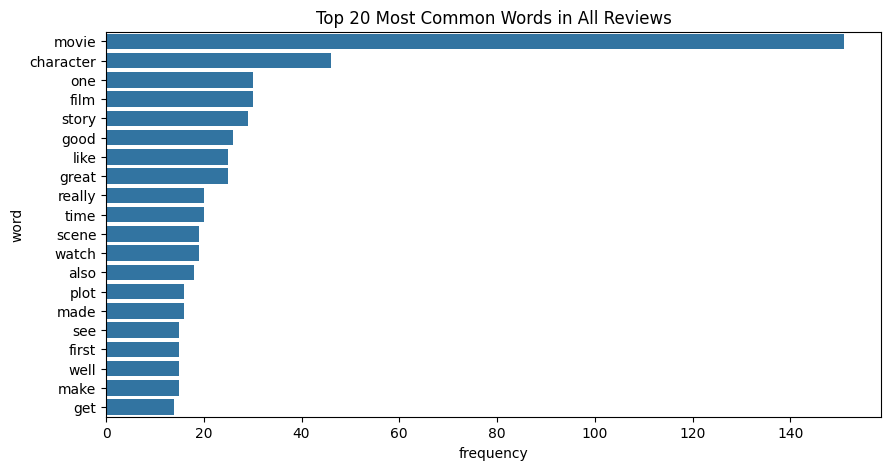

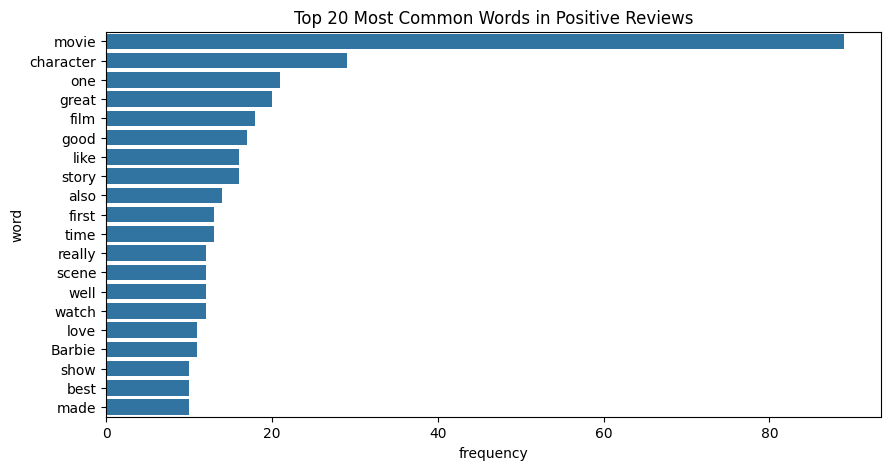

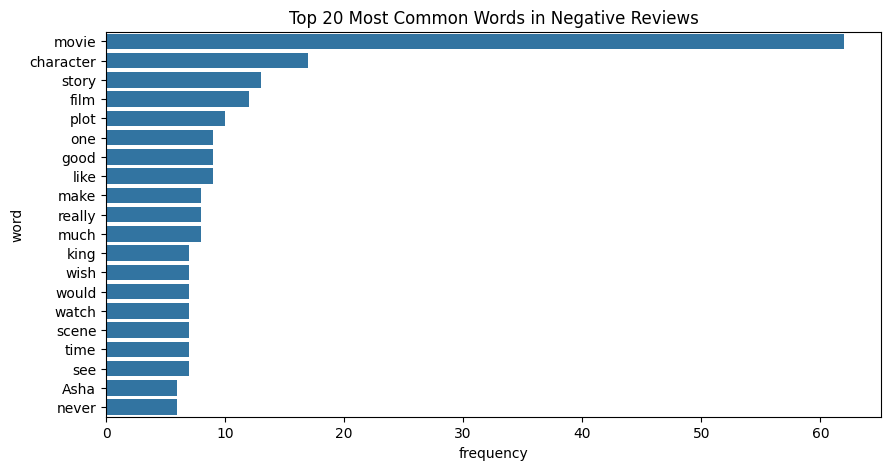

In [27]:
# Generate the word frequency plot
plot_word_frequency(all_reviews2, "All Reviews")
plot_word_frequency(positive_text2, "Positive Reviews")
plot_word_frequency(negative_text2, "Negative Reviews")

#### Word Frequency Plot Analysis

- **Overall New Test Reviews**: The word frequency plot for all new test reviews looks similar to the training data, with phrases such as "movie," "character," and "film" being the most frequently mentioned.

- **Positive Reviews**: In the plot for positive reviews, phrases like "great," "good," "like," "well," "love," and "best" are listed, reflecting a trend of positive sentiment. These frequent terms show that people tend to use similar phrases to express enjoyment in the reviews.

- **Negative Reviews**: The plot for negative reviews is less clear, with only one distinctly negative phrase, "never," appearing at the end of the chart. This suggests that the negative reviews may be less uniform, possibly due to varied ways of showing dislike.


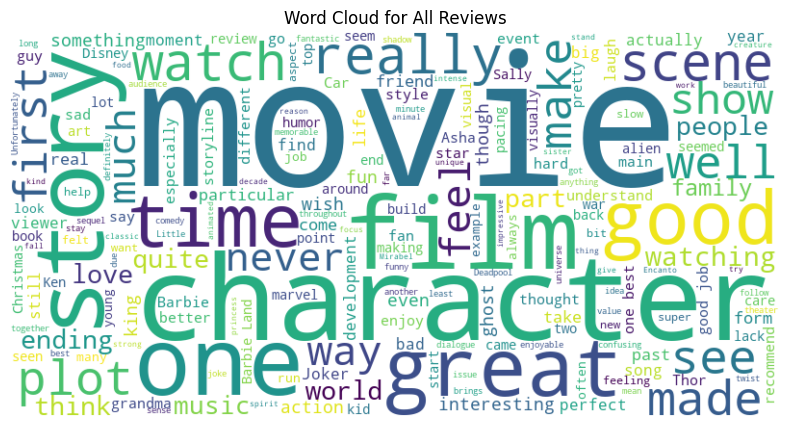

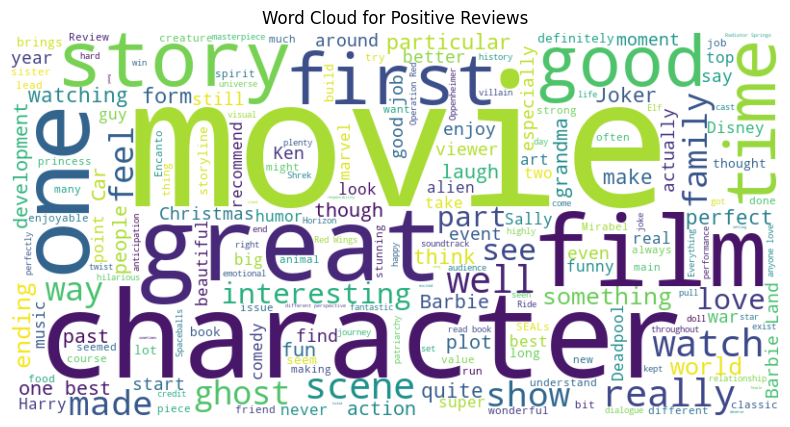

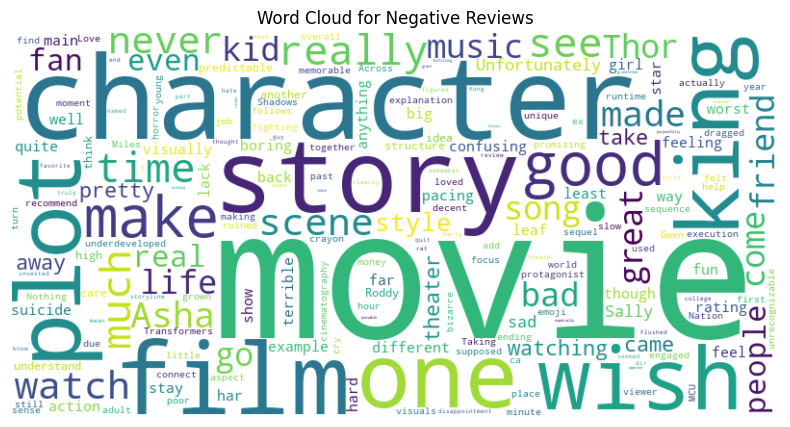

In [28]:
# Generate Wordcloud
generate_word_cloud(all_reviews2, "All Reviews")
generate_word_cloud(positive_text2, "Positive Reviews")
generate_word_cloud(negative_text2, "Negative Reviews")

#### Word Cloud Analysis

- **Positive Reviews**: The word cloud for positive reviews features words such as "great," "good," "perfect," "beautiful," "good job," "enjoy," "recommend," "best," and "hilarious." But only "great" and "good" are particularly noticeable, other phrases are much smaller and harder to spot.

- **Negative Reviews**: The word cloud for negative reviews includes terms like "good," "poor," "worst," "sad," "terrible," "bad," "great," "pretty," "boring," and "lack." However, "bad" is the only significantly large negative term, with "great" being the same size and "good" being larger and more eye-catching. The other negative phrases are very small and hard to see. This might make the classification harder since the negative phrases are not high frequency, and positive phrases are mixed in. 

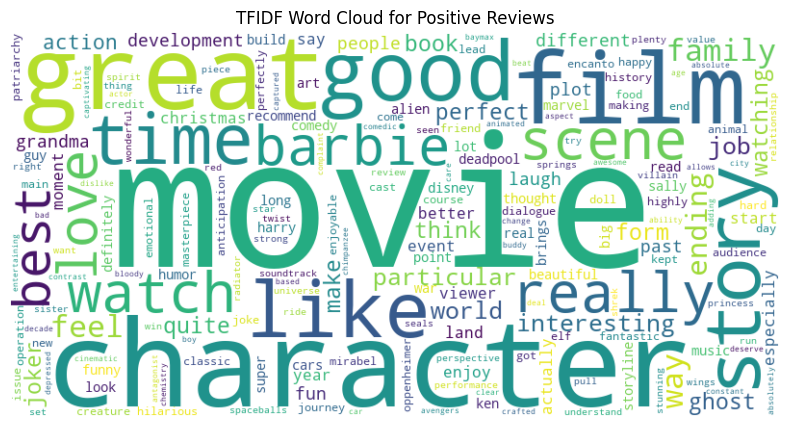

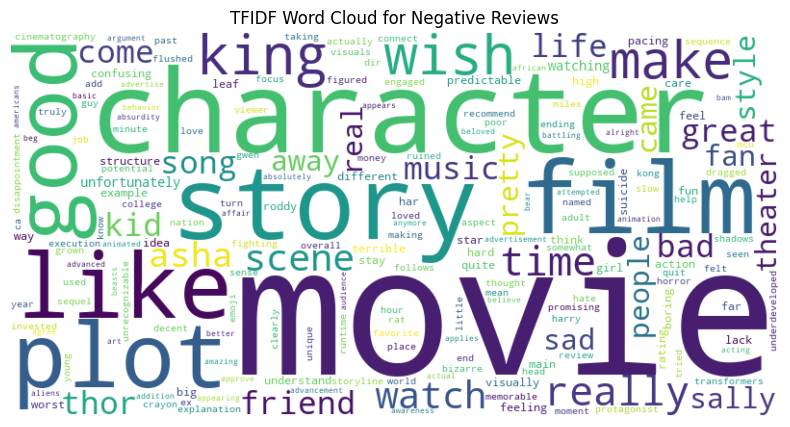

In [29]:
# generate world cloud with TFIDF vectorization
TFIDF_wordcloud(positive_text2, "Positive Reviews")
TFIDF_wordcloud(negative_text2, "Negative Reviews")

#### TF-IDF Word Cloud Analysis

- **Positive Reviews**: The TF-IDF word cloud for positive reviews is similar to the normal word cloud but with the positive phrases being more visible. Words like "great" and "good" stand out, with smaller terms like "love," "beautiful," "enjoy," "better," and "funny" also being noticeable. This emphasizes the positive sentiment more clearly.

- **Negative Reviews**: The TF-IDF word cloud for negative reviews is similarly not helpful like normal version. While "bad" and "great" are of similar sizes, other negative terms like "worst," "poor," "horror," "terrible," "unfortunately," and "sad" remain tiny. This suggests that the TF-IDF approach did not significantly enhance the visibility of negative phrases.

In [30]:
# TFIDF vector
# USe the same TF-IDF Vectorizer that the training dataset used

# vectorize new testing set
new_test_tfidf = tfidf_vectorizer.transform(df2['review'])

In [31]:
# Word2Vec

# Tokenize text for Word2Vec
tokenized_new_test = [review.split() for review in df2['review']]

# Word2Vec model has already been trained on the training data
# Function to get_average_word2vec already defined when vectorizing the training data

# Vectorize the new testing data
new_test_word2vec = np.array([get_average_word2vec(review, word2vec_model, 100) for review in tokenized_new_test])

# Print shape to check if vectorization is successful
print(f"Shape of new_test_word2vec: {new_test_word2vec.shape}")

Shape of new_test_word2vec: (60, 100)


### TASK 8: Test the Data and Analyze the Results (10 points)
For each model, compute accuracy, precision, recall, f1-score, and the confusion matrix. 

Compare the model performances based on performance on the testing.

In [35]:
# train the model, cross evaluate and make predictions on the new test data

def train_and_predict(models_vectors, y_train, y_new_test, batch_size=1000):
    """
    Train and validate models with different vector types, and predict on new test data.

    Args:
        models_vectors (dict): A dictionary pairing models with vectorizers, vector name, and their vectorized data.
        y_train (list): The training data labels.
        y_new_test (list): The new test data labels.
        batch_size (int): Size of the batches for partial fit.
    
    Outputs:
        Prints the model name and evaluation metrics including accuracy, precision, recall, and F1-score.
    """

    for name, (model, vector_name, (X_train_vec, X_test_vec, new_test_vec)) in models_vectors.items():
        # Perform cross-validation
        kf = KFold(n_splits=5)
        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []

        labels = np.array(y_train)
        for train_index, test_index in kf.split(X_train_vec):
            X_train_cv, X_test_cv = X_train_vec[train_index], X_train_vec[test_index]
            y_train_cv, y_test_cv = labels[train_index], labels[test_index]

            # Handle GaussianNB separately to avoid memory issues
            if isinstance(model, GaussianNB) and issparse(X_train_vec):
                model = partial_fit_gaussian_nb(X_train_cv, y_train_cv, batch_size)
                predictions = predict_in_batches(model, X_test_cv, batch_size)
            else:
                model.fit(X_train_cv, y_train_cv)
                predictions = model.predict(X_test_cv)

            accuracy_scores.append(accuracy_score(y_test_cv, predictions))
            precision_scores.append(precision_score(y_test_cv, predictions, average='weighted'))
            recall_scores.append(recall_score(y_test_cv, predictions, average='weighted'))
            f1_scores.append(f1_score(y_test_cv, predictions, average='weighted'))

        accuracy = np.mean(accuracy_scores)
        precision = np.mean(precision_scores)
        recall = np.mean(recall_scores)
        f1 = np.mean(f1_scores)

        # Display cross-validation performance
        print(f"Model: {name}")
        print(f"Vector Type: {vector_name}")
        print("  ▪️ Cross-Validation Performance:")
        print(f"    - Accuracy: {accuracy:.2f}")
        print(f"    - Precision: {precision:.2f}")
        print(f"    - Recall: {recall:.2f}")
        print(f"    - F1-Score: {f1:.2f}")

        # Make predictions on the new test data
        new_test_pred = model.predict(new_test_vec)
        accuracy_new_test = accuracy_score(y_new_test, new_test_pred)
        precision_new_test = precision_score(y_new_test, new_test_pred, average='weighted')
        recall_new_test = recall_score(y_new_test, new_test_pred, average='weighted')
        f1_new_test = f1_score(y_new_test, new_test_pred, average='weighted')
        
        # Confusion Matrix
        conf_matrix = confusion_matrix(y_new_test, new_test_pred)

        # Display new test data performance
        print("  ▪️ New Test Data Performance:")
        print(f"    - Accuracy: {accuracy_new_test:.2f}")
        print(f"    - Precision: {precision_new_test:.2f}")
        print(f"    - Recall: {recall_new_test:.2f}")
        print(f"    - F1-Score: {f1_new_test:.2f}")
        print("  ▪️ Confusion Matrix - New Test Data Prediction:")
        print(f"     Predicted:  0  1")
        print(f"     Actual 0: [{conf_matrix[0, 0]:2d} {conf_matrix[0, 1]:2d}]")
        print(f"            1: [{conf_matrix[1, 0]:2d} {conf_matrix[1, 1]:2d}]")
        print("------------------------")


In [36]:
# Pair up the classifiers and their corresponding vectorized data
classifiers_vectorization = {
    'MultinomialNB': (MultinomialNB(), "TF-IDF Vector", (X_train_tfidf, X_test_tfidf, new_test_tfidf)),
    'BernoulliNB': (BernoulliNB(), "TF-IDF Vector", (X_train_tfidf, X_test_tfidf, new_test_tfidf)),
    'GaussianNB': (GaussianNB(), "Word2Vec", (X_train_word2vec, X_test_word2vec, new_test_word2vec))
}

# Collect the true labels for the new test data
y_new_test = df2['class']

# Train models and predict on new test data
train_and_predict(classifiers_vectorization, y_train, y_new_test)

Model: MultinomialNB
Vector Type: TF-IDF Vector
  ▪️ Cross-Validation Performance:
    - Accuracy: 0.86
    - Precision: 0.86
    - Recall: 0.86
    - F1-Score: 0.86
  ▪️ New Test Data Performance:
    - Accuracy: 0.90
    - Precision: 0.90
    - Recall: 0.90
    - F1-Score: 0.90
  ▪️ Confusion Matrix - New Test Data Prediction:
     Predicted:  0  1
     Actual 0: [19  4]
            1: [ 2 35]
------------------------
Model: BernoulliNB
Vector Type: TF-IDF Vector
  ▪️ Cross-Validation Performance:
    - Accuracy: 0.85
    - Precision: 0.85
    - Recall: 0.85
    - F1-Score: 0.85
  ▪️ New Test Data Performance:
    - Accuracy: 0.83
    - Precision: 0.85
    - Recall: 0.83
    - F1-Score: 0.84
  ▪️ Confusion Matrix - New Test Data Prediction:
     Predicted:  0  1
     Actual 0: [21  2]
            1: [ 8 29]
------------------------
Model: GaussianNB
Vector Type: Word2Vec
  ▪️ Cross-Validation Performance:
    - Accuracy: 0.67
    - Precision: 0.67
    - Recall: 0.67
    - F1-Score: 0

### Analysis on Results

1. **MultinomialNB with TF-IDF Vector**:
   - **Cross-Validation Performance**: The model performed well with an accuracy of 0.86 and similarly high precision, recall, and F1-scores.
   - **New Test Data Performance**: The performance improved, having an 0.90 in accuracy, precision, recall, and F1-score, which is quite impressive. This indicates that the MultinomialNB model generalized well to the new test data, slightly outperforming the cross-validation results.
   - **Confusion Matrix**:
     - Out of the 60 new test data points, the model had 54 correct predictions. Of these, 19 were true negatives and 35 were true positives. It also had 2 false negatives and 4 false positives.

2. **BernoulliNB with TF-IDF Vector**:
   - **Cross-Validation Performance**: Consistent performance with an accuracy, precision, recall, and F1-score of 0.85.
   - **New Test Data Performance**: Slightly lower accuracy at 0.83, but still pretty good with precision and F1-scores remaining relatively high at 0.85 and 0.84, respectively. This shows the model's reliability, though there's a slight drop compared to cross-validation.
   - **Confusion Matrix**:
     - Out of the 60 new test data points, the model had 50 correct predictions. Of these, 21 were true negatives and 29 were true positives. It also had 8 false negatives and 2 false positives.
     
3. **GaussianNB with Word2Vec**:
   - **Cross-Validation Performance**: The model had the lowest performance in cross-validation with an accuracy of 0.67, indicating that either the data or vectorization process needs further handling, or this model and vector combinations just doesn't suited this task.
   - **New Test Data Performance**: Interestingly, the model performed better on the new test data with an accuracy of 0.73 and slightly improved precision, recall, and F1-scores at 0.74. Despite the initial low cross-validation scores, the model showed some when predicting unseen data, though it remains the model with the worst performance overall.
   - **Confusion Matrix**:
     - Out of the 60 new test data points, the model had 42 correct predictions. Of these, 15 were true negatives and 27 were true positives. It also had 10 false negatives and 8 false positives.
     
In conclusion, MultinomialNB with TF-IDF vectorization appears to be the best-performing combination for this text classification task, showing good generalization with high accuracy. BernoulliNB is also reliable, while GaussianNB with Word2Vec, although less performant, shows some potential with the better performance on new test data.

**End Note**:
Code draft by AI; I did the tweaking, troubleshooting, and combined repeating code into functions. I also wrote the analysis, AI was used for formatting and grammar check.